# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    get_ipython().run_line_magic('load_ext', 'autoreload')

get_ipython().run_line_magic('autoreload', '2')


# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# models
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.classifier import LogisticRegression as extLogisticRegression
# xgboost
from xgboost import XGBClassifier

# processing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn import model_selection

# feature selection
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold, chi2

# feature agglomeration
from sklearn.cluster import FeatureAgglomeration

# benchmark
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, multilabel_confusion_matrix, auc, matthews_corrcoef, roc_auc_score, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pickle

# Visualizations
import matplotlib.pyplot as plt
# Set default font size
plt.rcParams['font.size'] = 24
import seaborn as sb
# Set default font size
sb.set(font_scale = .8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)

# Interactive Visualizations
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# icf.set_config_file(theme='white')

# Analysis/Modeling
Do work here

In [2]:
target_col = "Cetuximab_Standard_3wks_cat"

# K5 clusters encoded meth probes
f = "tables/preprocessed_features/methK5Clusters.tsv"
Meth = pd.read_csv(f, sep="\t", header=0, index_col=0)
Meth = Meth[Meth.columns.drop(list(Meth.filter(regex='Cetuximab')))]

# exncoded expr data w/t progeny pathway activity scores
f = "tables/preprocessed_features/exprPath.tsv"
Expr = pd.read_csv(f, sep="\t", header=0, index_col=0)
Expr = Expr[Expr.columns.drop(list(Expr.filter(regex='Cetuximab')))]
Expr.columns = [c + "_expr" for c in Expr.columns]

f = "tables/preprocessed_features/CNV.tsv"
CNV = pd.read_csv(f, sep="\t", header=0, index_col=0)
CNV = CNV[CNV.columns.drop(list(CNV.filter(regex='Cetuximab')))]
CNV.columns = [c + "_cnv" for c in CNV.columns]

f = "tables/preprocessed_features/mut_ComboMulti.tsv"
Mut = pd.read_csv(f, sep="\t", header=0, index_col=0)
Mut = Mut[Mut.columns.drop(list(Mut.filter(regex='Cetuximab')))]
Mut.columns = [c + "_mut" for c in Mut.columns]

# add clinical data
f = 'tables/preprocessed_features/clin.tsv'
Clin = pd.read_csv(f, sep="\t", header=0, index_col=0)
Clin = Clin[Clin.columns.drop(list(Clin.filter(regex='Cetuximab')))]
Clin.columns = [c + "_clin" for c in Clin.columns]

f = "tables/DrugResponse_LMXfirslevel_trainTest.csv"
Y = pd.read_csv(f, sep="\t", index_col=1, header=0)
# encode target
Y_class_dict={'PD':0,'SD':1, 'OR':1}
Y[target_col] = Y[target_col].replace(Y_class_dict)

df1 = pd.merge(Mut, CNV, right_index=True, left_index=True, how="outer")
df2 = pd.merge(Meth, Expr, right_index=True, left_index=True, how="outer")
all_df = pd.merge(df2, df1, right_index=True, left_index=True, how="outer")
all_df = pd.merge(all_df, Clin, right_index=True, left_index=True, how="outer")
feature_col = all_df.columns.tolist()
all_df =  all_df.select_dtypes([np.number])
all_df = pd.merge(all_df, Y[target_col], right_index=True, left_index=True, how="right")

# fillna in features with median imputation
all_df[feature_col] = all_df[feature_col].    astype(float).apply(lambda col:col.fillna(col.median()))
# drop duplicated instances (ircc_id) from index
all_df = all_df[~all_df.index.duplicated(keep='first')]

top5 = [
        "KRAS_BRAF_NRAS_triple_neg_mut",
        "EGFR_expr",
        "MAPK_expr",
        "TGFb_expr",
        "KRAS_mut"
]

# train-test split
train_models = Y[Y.is_test == False].index.unique()
test_models = Y[Y.is_test == True].index.unique()
X_train = all_df.loc[train_models, top5]
y_train  = all_df.loc[train_models, target_col]
X_test = all_df.loc[test_models, top5]
y_test = all_df.loc[test_models, target_col]

#scale features sapartaely
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train.values),
          columns=X_train.columns, index=X_train.index)              
X_test = pd.DataFrame(scaler.transform(X_test.values),
          columns=X_test.columns, index=X_test.index)    
X_train.shape
X_test.shape


(174, 5)

(57, 5)

In [3]:
# basic classifier accuracy test
lr = LogisticRegression().fit(X_train, y_train)
svm = LinearSVC().fit(X_train, y_train)
knc = KNeighborsClassifier().fit(X_train, y_train)
rfc = RandomForestClassifier().fit(X_train, y_train)
xgc = XGBClassifier().fit(X_train, y_train)
[(model, accuracy_score(y_test, model.predict(X_test))) for model in [lr, svm, knc, rfc, xgc]]

/home/umberto.perron/anaconda3/envs/PDx_py_combio02/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:59:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[(LogisticRegression(), 0.7719298245614035),
 (LinearSVC(), 0.7719298245614035),
 (KNeighborsClassifier(), 0.6140350877192983),
 (RandomForestClassifier(), 0.7017543859649122),
 (XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None),
  0.631578947368421)]

# Results
Show graphs and stats here

Accuracy on test set: 0.772
              precision    recall  f1-score   support

          PD       0.95      0.62      0.75        32
       SD-OR       0.67      0.96      0.79        25

    accuracy                           0.77        57
   macro avg       0.81      0.79      0.77        57
weighted avg       0.83      0.77      0.77        57



0.78

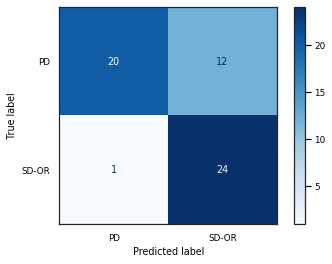

In [5]:
# load the model from file
classifier = lr
# assess best classifier performance on test set
grid_test_score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)
print(f'Accuracy on test set: {grid_test_score:.3f}')
# print classification report on test set
print(classification_report(y_test, y_pred, target_names=['PD', 'SD-OR']))


# In[71]:


#confusion_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=['PD', 'SD-OR'],
                                 cmap=plt.cm.Blues)


# In[72]:


# Learn to predict e/a class against e/a other
#OVRclassifier = OneVsRestClassifier(classifier)
# returns the marginal probability that the given sample has the label in question
y_test_predict_proba = classifier.predict_proba(X_test)
roc_auc_score(y_test, y_test_predict_proba[:, 1])

# Conclusions and Next Steps
Summarize findings here